In this tutorial we'll:

1. Briefly talk about neural networks, deep learning, and multiclass classification
2. Use Keras build models to learn the "MNIST" dataset
3. We'll first use Perceptron
4. We'll then use a simple neural network very similar to Perceptron called a "Multilayer Perceptron"
5. We'll investigating how changing the number of layers effects the accuracy
6. We'll look at a fancier way to combine the layers, and how that can improve performance
6. We'll briefly see a fancier network that gets nearly state of the art (99%!) accuracy


# Part 1: Background 

## What are neural networks & deep learning?

We'll talk about them in class soon! One good source of explanation is: http://neuralnetworksanddeeplearning.com/chap1.html

We've already seen Perceptron in class

<img src="perceptron.png" width="300">

When we used Perceptron in class, we classified based on whether the dot product of the example and the weights was *less than 0*. In neural networks this function- which decides whether or not an example is positive based on this dot product- is called an *activation function*. Many neural networks can learn non-linear functions because they use other activation functions such as "relu".

A neural network is made by chaining a few Perceptron "neurons" togther:

<img src="nn.png" width="300">

What you need to know:

* A neural network is a non-linear classifier, like a decision tree

* In practice, they seem to work very well for certain kinds of data including images and text

* Neural networks are organized into "layers". Lots of choices of how exactly you set up these layer; a "deep neural network" is a neural network with many layers.

* A perceptron is a very simple neural network (a single-layer neural network neural network)


## What is Keras & what is it used for?

Keras is a library for deep learning, designed to make common types of neural networks very easy to work with.

* It's a layer on top of a more powerful, but more difficult to use, library called TensorFlow.

* If you want to use "standard" neural nets, Keras is better; if you want to use very fancy or complicated models you should use Tensorflow.
    
* Tons of examples:
https://github.com/fchollet/keras/tree/master/examples

You can create a model in Keras by specifying which model you want to use, and how you want to train it; Keras takes care of the rest. Keras has many options of "standard" models.
    
-----

# Part 2: Learning the MNIST Dataset in Keras: Setting up the Data

Adapted from https://github.com/fchollet/keras/blob/master/examples/mnist_mlp.py

Handwritten digit dataset taken from high school students:

<img src="mnist.png" width="300">

There are 70,000 examples to test and train on, with 10 labels (the digits 0 through 9)

The state-of-the art accuracy for this dataset is 99.79% accuracy!

### Multi-class classification

Because there are 10 labels, we're actually going to need a multi-class classifier.


#### Training a 10 way classifier: train 10 binary classifiers
What this actually means is we're going to train 10 binary perceptrons!

ie: 

a "0 or not 0" classifier

a "1 or not 1" classifier

a "2 or not 2" classifier

etc

#### Testing with a 10 way classifier: let all the classifiers "vote"

Then, at test time, each perceptron "votes" and we choose the label based on the "most confident" vote.

ie, at test time we have an example that is truely a "1"

the "0 or not 0" classifier returns a negative value (meaning "it's not a 0!")

the "1 or not 1" classifier returns **a positive value** (meaning "it's a 1!")

the "2 or not 2" classifier returns a negative value (meaning "it's not a 2!")

etc

so we label the example as a "1".


### Getting set up with MNIST

Note: use Shift+Enter to run the codeblocks

In [148]:
import keras
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout
from keras.optimizers import SGD, Adam

# Configure matplotlib figure size and make inline
matplotlib.rcParams['figure.figsize'] = [10, 6]
%matplotlib inline

### Split our data into a training & testing set

`x_train` & `x_test` are the examples, and `y_train` & `y_test` are the labels.

In [104]:
# the data, shuffled and split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_train = x_train.reshape(60000, 784)
x_test  = x_test.reshape(10000, 784)
x_train = x_train.astype('float32')
x_test  = x_test.astype('float32')

# normalize the pixel values to be in the range (0, 1)
x_train /= 255 
x_test  /= 255


print("Number of training samples: " + str(x_train.shape[0]))
print("Number of testing samples: " + str(x_test.shape[0]))


Number of training samples: 60000
Number of testing samples: 10000


### Check out what our data looks like

Let's plot one of the training examples

The shape of each image is(784,)


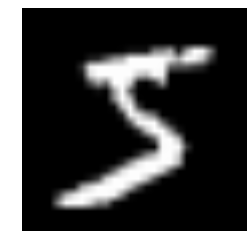

In [105]:
image = x_train[0]
img_rows, img_cols, channels = 28, 28, 1
image = np.reshape(image, [img_rows, img_cols])
plt.imshow(image, cmap='gray')
plt.axis('off')

# The shape of each image is a vector with 784 binary values ("pixels")
image_shape = x_train[0].shape
print("The shape of each image is" + str(image_shape))

### Great, let's make format our labels

The labels are currently formatted as numeric values, ie the image above has the label `5`.

Since we're training 10 binary perceptron classifiers, we need to convert the labels into binary values.

ie, the label `1` becomes the array `[0, 1, 0, 0, 0, 0, 0, 0, 0, 0]`. The entry in the "1th" position is true, and all others are false. 


In [106]:
# classifying 10 digits
num_classes = 10


print("shape of our labels before" + str(y_train.shape))
print("the first 3 labels look like:") 
print(str(y_train[0:5]) + '\n')


# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

print("shape of our labels after" + str(y_train.shape))
print("the first 3 labels look like:") 
print(str(y_train[0:5]))

shape of our labels before(60000,)
the first 3 labels look like:
[5 0 4 1 9]

shape of our labels after(60000, 10)
the first 3 labels look like:
[[ 0.  0.  0.  0.  0.  1.  0.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]]


-----

# Part 3: Using Perceptron to learn MNIST!

Now that our data is good to go, let's train our 10 perceptrons!


### Let's make our model!!

We're going to train a model that Keras calls a "Sequential" model.

TODO ADD DIAGRAM

Sequential is an abstraction for really simple networks. There are many ways you can "link" the neurons between layers in a neural network, and "Sequential" is the simplest way to link these layers. Since we're training perceptrons, which are single layer networks, this doesn't really concern us.

Sidenote: The alternative to in Keras to Sequential models are "Functional" models. You can use those to make fancier networks.



In [107]:

perceptron_model = Sequential()
perceptron_model.add(Dense(num_classes, activation='softmax', input_shape=image_shape))

perceptron_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_81 (Dense)             (None, 10)                7850      
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


### Summary: what does this tell us?

Since we have a lot more data points (60,000) than parameters to train (7850) we're good to go. --> Maybe this is confusing.

todo: maybe visualize

### Compiling the model

Now that we've told the Keras *what the model is*, we now need to tell it *how to learn*.

1. What's the loss function?

    In class we've seen some loss functions like the hinge loss and the SVM loss. Here we're going to use a different loss function called the "categorical crossentropy" loss. Cross-entropy is a loss function that works well for learning because it makes learning very fast when your function is "very wrong" but slower when it is pretty close to the true function.


2. What's the optimizer?

    We'll use SGD (Stochastic Gradient Descent) which we've already discussed in class.
    

3. Which metric to optimize?

    We'll use accuracy- which is what we've been using for our algorithms all semester. There are some other options that make sense for other types of datasets. 

In [108]:
perceptron_model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

### Fit the model & store accuracies!

Note: turning on verbosity can slow things down *a lot* so if you're running some large model, turn it off.

In [109]:
global_batch_size = 128
num_epochs = 10

history = perceptron_model.fit(x_train, y_train,
                   batch_size=global_batch_size, # average 128 examples in each SGD test
                   epochs=num_epochs,
                   verbose=1,
                   validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 1s - loss: 1.2739 - acc: 0.7013 - val_loss: 0.8105 - val_acc: 0.8340
Epoch 2/10
60000/60000 [==============================] - 0s - loss: 0.7183 - acc: 0.8391 - val_loss: 0.6083 - val_acc: 0.8614
Epoch 3/10
60000/60000 [==============================] - 0s - loss: 0.5895 - acc: 0.8583 - val_loss: 0.5266 - val_acc: 0.8741
Epoch 4/10
60000/60000 [==============================] - 0s - loss: 0.5273 - acc: 0.8684 - val_loss: 0.4812 - val_acc: 0.8801
Epoch 5/10
60000/60000 [==============================] - 0s - loss: 0.4894 - acc: 0.8749 - val_loss: 0.4512 - val_acc: 0.8846
Epoch 6/10
60000/60000 [==============================] - 0s - loss: 0.4633 - acc: 0.8795 - val_loss: 0.4297 - val_acc: 0.8878
Epoch 7/10
60000/60000 [==============================] - 0s - loss: 0.4439 - acc: 0.8836 - val_loss: 0.4134 - val_acc: 0.8910
Epoch 8/10
60000/60000 [==============================] - 0s 

### Check out those accuracies!

90% lookin good!

Let's try it on our *test set* instead of our *validation set* now


In [110]:
score = perceptron_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

('Test loss:', 0.3815837455511093)
('Test accuracy:', 0.89739999999999998)


-----

# Part 4: learning MNIST with a Multilayer Perceptron!

We'll set up a new model

TODO ADD DIAGRAM OF WHAT THIS IS

In [111]:
mlp_model = Sequential()
mlp_model.add(Dense(512, activation='relu', input_shape=image_shape))
mlp_model.add(Dense(256, activation='relu'))
mlp_model.add(Dense(num_classes, activation='softmax'))

mlp_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_82 (Dense)             (None, 512)               401920    
_________________________________________________________________
dense_83 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_84 (Dense)             (None, 10)                2570      
Total params: 535,818
Trainable params: 535,818
Non-trainable params: 0
_________________________________________________________________


### Compile the MLP

We'll compile with the same parameters as before so that it's a fair comparison.

In [112]:
mlp_model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])

### Fit & Evaluate

In [113]:
global_batch_size = 128
num_epochs = 10

history = mlp_model.fit(x_train, y_train,
                   batch_size=global_batch_size, # average 128 examples in each SGD test
                   epochs=num_epochs,
                   verbose=1,
                   validation_data=(x_test, y_test))

score = mlp_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


Train on 60000 samples, validate on 10000 samples
Epoch 1/10
60000/60000 [==============================] - 3s - loss: 1.0895 - acc: 0.7481 - val_loss: 0.5185 - val_acc: 0.8759
Epoch 2/10
60000/60000 [==============================] - 3s - loss: 0.4457 - acc: 0.8825 - val_loss: 0.3666 - val_acc: 0.9022
Epoch 3/10
60000/60000 [==============================] - 3s - loss: 0.3556 - acc: 0.9009 - val_loss: 0.3167 - val_acc: 0.9124
Epoch 4/10
60000/60000 [==============================] - 3s - loss: 0.3152 - acc: 0.9114 - val_loss: 0.2891 - val_acc: 0.9181
Epoch 5/10
60000/60000 [==============================] - 3s - loss: 0.2887 - acc: 0.9175 - val_loss: 0.2682 - val_acc: 0.9228
Epoch 6/10
60000/60000 [==============================] - 3s - loss: 0.2689 - acc: 0.9231 - val_loss: 0.2510 - val_acc: 0.9286
Epoch 7/10
60000/60000 [==============================] - 3s - loss: 0.2525 - acc: 0.9281 - val_loss: 0.2396 - val_acc: 0.9313
Epoch 8/10
60000/60000 [==============================] - 3s 

-----
# Part 5: How deep can you go: can adding more layers help us?

Creating a deep model gives us some performance gains, but it's not a panacea.  Let's see how model performance behaves as we add more layers.

In [156]:
def depth_accuracy_analysis(x_train, y_train, x_test, y_test, max_layers, layer_size =128, verbose=False):
    # type: (np.ndarray, np.ndarray, np.ndarray, np.ndarray, int, int, bool) -> List[float]
    """This method creates deep feedforward networks of varyig depth from 1 layer to max_layers.  It
    returns a list of accuracies on the test set
    
    Args:
        x_train: An np.ndarray of data where each row is a new data point
        y_train: An np.ndarray of labels where each row is a binary vector with
            1 in the column of the associated class
        x_test: An np.ndarray of data where each row is a new data point
        y_test: An np.ndarray of labels where each row is a binary vector with
            1 in the column of the associated class
        max_layers: An int the maximum depth to try
        layer_size: The number of neurons in each layer
    
    Returns:
        A List of floats as the accuracies of the model on the test set
    """
    
    # todo:: num_classes
    acc_scores = []
    
    # Build up and test 1 - max layers
    for i in range(0, max_layers):
        mlp_model = Sequential()
        mlp_model.add(Dense(layer_size, activation='relu', input_shape=x_train[0].shape))
        
        # Add i layers
        for j in range(1, i):
            mlp_model.add(Dense(layer_size, activation='relu'))

        mlp_model.add(Dense(num_classes, activation='softmax'))
        mlp_model.compile(loss='categorical_crossentropy', optimizer=SGD(), metrics=['accuracy'])
        history = mlp_model.fit(x_train, y_train,
                        batch_size=128,
                        epochs=10,
                        verbose=0,
                        validation_data=(x_test, y_test))
        score = mlp_model.evaluate(x_test, y_test, verbose=0)
        
        # Print out scores if verbosity is non 0
        if verbose:
            print('Test loss:', score[0])
            print('Test accuracy:', score[1])
        acc_scores.append(score)
    
    return acc_scores

In [158]:
max_layers = 30
layer_size = 128
scores = depth_accuracy_analysis(x_train, y_train, x_test, y_test, max_layers, layer_size=layer_size)

('Test loss:', 0.27617252286970617)
('Test accuracy:', 0.92330000000000001)
('Test loss:', 0.27529134869873523)
('Test accuracy:', 0.92479999999999996)
('Test loss:', 0.23313846810609101)
('Test accuracy:', 0.93320000000000003)


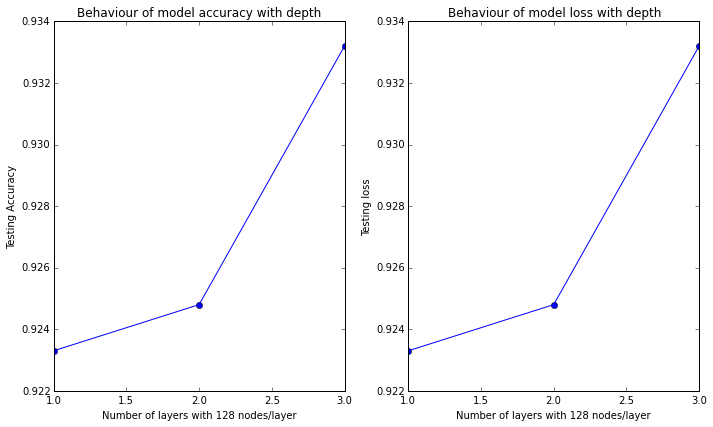

In [159]:
matplotlib.rcParams['figure.figsize']

plt.subplot(1, 2, 1)

# Plot Accuracy
plt.plot(range(1, max_layers + 1), map(lambda x: x[1], scores), 'o-')
plt.title('Behaviour of model accuracy with depth')
plt.ylabel('Testing Accuracy')
plt.xlabel('Number of layers with {} nodes/layer'.format(layer_size))

# Plot Loss
plt.subplot(1, 2, 2)
plt.plot(range(1, max_layers + 1), map(lambda x: x[1], scores), 'o-')
plt.title('Behaviour of model loss with depth')
plt.ylabel('Testing loss')
plt.xlabel('Number of layers with {} nodes/layer'.format(layer_size))
plt.tight_layout()
plt.show()

-----

# Part 6: If adding more layers isn't helping, can we get smarter about the network?

----
# Part 7: State of the Art-ish Accuracy

----
# Part 8: Cool stuff with neural nets

Michael Nielsen's book is awesome: http://neuralnetworksanddeeplearning.com/

Lots of keras tutorials: https://github.com/fchollet/keras/tree/master/examples

"Deep art": https://deepart.io/

Twitter bot neural net text generation: https://twitter.com/DeepProverbs

Adversarial 

Generated cat images from outlines: https://affinelayer.com/pixsrv/
